<a href="https://colab.research.google.com/github/annisajumalia/202055202012-anisa/blob/master/jenisgulamerah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle datasets download -d annisajumalia/gula-merah
!mkdir gula-merah
!unzip /content/gula-merah.zip -d /content/gula-merah

 35% 5.00M/14.3M [00:00<00:00, 29.9MB/s]
100% 14.3M/14.3M [00:00<00:00, 70.4MB/s]
Archive:  /content/gula-merah.zip
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (1).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (10).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (11).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (12).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (13).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (14).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (15).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (16).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (17).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (18).jpg  
  inflating: /content/gula-merah/GULA/GUA MERAH JAWA/gulamerahjawa (19).jpg  
  inflating: /content/gula-

In [3]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [4]:
dataset_path = Path(r'/content/gula-merah')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [5]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/gula-merah/GULA/GULA AREN/gulaaren (4...,GULA AREN
1,/content/gula-merah/GULA/GULA AREN/gulaaren (2...,GULA AREN
2,/content/gula-merah/GULA/GULA AREN/gulaaren (9...,GULA AREN
3,/content/gula-merah/GULA/GULA AREN/gulaaren (2...,GULA AREN
4,/content/gula-merah/GULA/GULA AREN/gulaaren (8...,GULA AREN


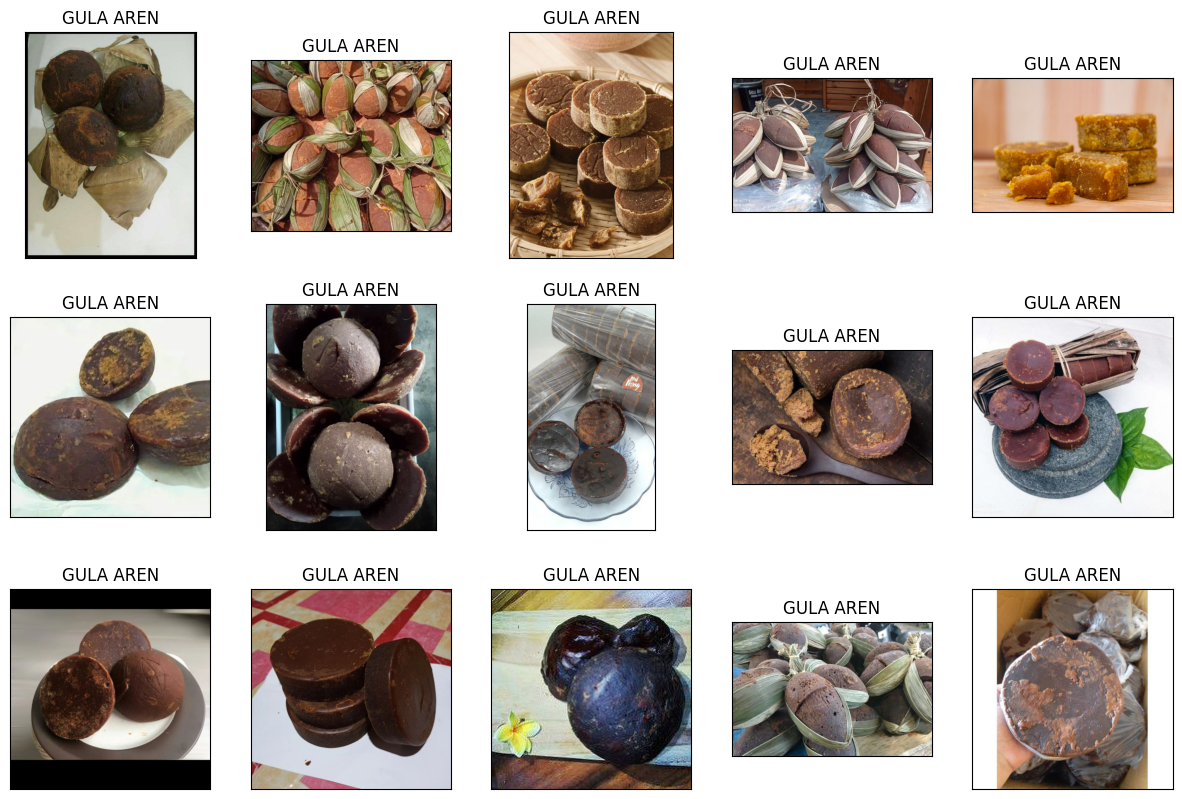

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [7]:
df.label.value_counts()

GULA AREN         100
MANADO            100
GUA MERAH JAWA    100
Name: label, dtype: int64

In [8]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

GULA AREN         100
MANADO            100
GUA MERAH JAWA    100
Name: label, dtype: int64

In [9]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [10]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [11]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 168 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [12]:
input_shape = (200, 200, 3)

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [14]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
6/6 [==============================] - 19s 3s/step - loss: 1.1101 - accuracy: 0.3333 - val_loss: 1.0822 - val_accuracy: 0.3810
Epoch 2/100
6/6 [==============================] - 16s 3s/step - loss: 1.1028 - accuracy: 0.3571 - val_loss: 1.0805 - val_accuracy: 0.3810
Epoch 3/100
6/6 [==============================] - 15s 3s/step - loss: 1.0889 - accuracy: 0.3512 - val_loss: 1.0395 - val_accuracy: 0.3810
Epoch 4/100
6/6 [==============================] - 15s 2s/step - loss: 1.0626 - accuracy: 0.3631 - val_loss: 0.9858 - val_accuracy: 0.3810
Epoch 5/100
6/6 [==============================] - 15s 3s/step - loss: 1.0485 - accuracy: 0.4583 - val_loss: 0.9440 - val_accuracy: 0.5714
Epoch 6/100
6/6 [==============================] - 15s 3s/step - loss: 1.0700 - accuracy: 0.4821 - val_loss: 0.8897 - val_accuracy: 0.6190
Epoch 7/100
6/6 [==============================] - 15s 2s/step - loss: 1.0173 - accuracy: 0.4940 - val_loss: 0.9721 - val_accuracy: 0.4762
Epoch 8/100
6/6 [==========

In [15]:
model.save('model-1.h5')

In [16]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

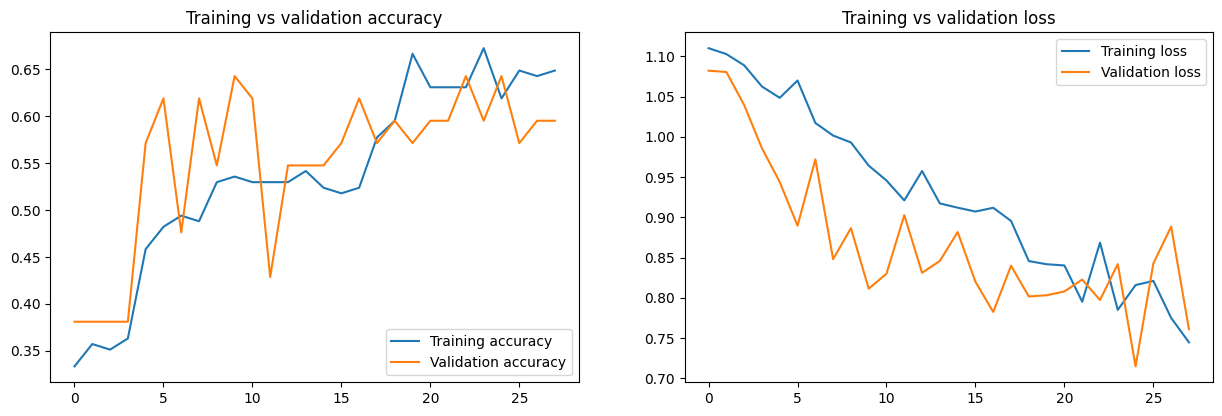

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [19]:
pred = model.predict(test)

3/3 [==============================] - 3s 679ms/step


In [20]:
pred = np.argmax(pred, axis=1)

In [21]:
labels = train.class_indices

In [22]:
labels

{'GUA MERAH JAWA': 0, 'GULA AREN': 1, 'MANADO': 2}

In [23]:
labels = dict((v,k) for k, v in labels.items())

In [24]:
labels

{0: 'GUA MERAH JAWA', 1: 'GULA AREN', 2: 'MANADO'}

In [25]:
y_pred = [labels[k] for k in pred]

In [26]:
print(classification_report(x_test.label, y_pred))

                precision    recall  f1-score   support

GUA MERAH JAWA       0.51      0.88      0.65        24
     GULA AREN       0.50      0.36      0.42        33
        MANADO       0.64      0.48      0.55        33

      accuracy                           0.54        90
     macro avg       0.55      0.57      0.54        90
  weighted avg       0.55      0.54      0.53        90



In [27]:
print(confusion_matrix(x_test.label, y_pred))

[[21  3  0]
 [12 12  9]
 [ 8  9 16]]


In [28]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 3s 668ms/step - loss: 0.9475 - accuracy: 0.5222
